# ASSIGNMENT 5: TEXTUAL ANALYSIS FOR 10-K REPORTS

## Summary
&nbsp;&nbsp;&nbsp;&nbsp;The question for this analysis is, does the sentiment of a 10-K filing have any immediate (within 10 days) affect on the company's stock performance? To conduct this analysis, I calculated positive and negative sentiment scores for each 10-K for firms in the S&P 500 and compared those scores to the stock return. <br>
&nbsp;&nbsp;&nbsp;&nbsp;The results of this study are difficult to understand for me, however I found that sentiment, whether positive or negative, has little effect on return around the filing date of a 10-K. The correlations of each variable are low, and the data is largely situated in a single cluster. Sentiment scores varied across the different dictionaries, but there is not much difference in return compared to the scores.

## 2. Data

The sample used for this analysis was the most recent 10-K filing from firms in the S&P 500 as of December 2022. Along with these filings, the daily returns for dates around the filing are used to compare the sentiment of the text to actual stock performance. More specifically the return on the day of the filing up to 10 days after.

The return variables are built by taking the filing date and the next 10 dates after it and finding cumulative return.
- `v1` is a the return on the date of the filing
- `v2` is a the cumulative return on the date of the filing and the next two days
- `v3` is a the cumulative return on the date of the filing and the next nine days
The following is the process of creating return variables, explained by the comments
```python
# First: calculated the cumulative product of the return variables. ret_1 is ret + 1
firm_ret_data = firm_ret_data.assign(cum_ret = lambda x: x.groupby(['ticker'])['ret_1'].cumprod() - 1)

# Second: Find return where filing_date == date
matching_rows = firm_ret_data[firm_ret_data['filing_date'] == firm_ret_data['date']]

isolated_indices = []

# Third: get the returns for the v2 and v3 variables. This searches the index for the dates we want.
for index in matching_rows.index:
    if index in firm_ret_data.index:
        isolated_indices.append(index)
    if index + 2 in firm_ret_data.index:
        isolated_indices.append(index + 2)
    if index + 9 in firm_ret_data.index:
        isolated_indices.append(index + 9)

# Last: Add the cumulative returns to a new dataframe for only the selected dates.
firm_ret_data = firm_ret_data.loc[isolated_indices]
firm_ret_data_final = firm_ret_data[['ticker','date','cum_ret']]
```

The sentiment variables are essentially the number of words from given dictionaries divided by the total length of the document. These variables act as an index that measures the general tone of the 10-K report. The following is an example of how one of the variables was created, explained by the comments.
```python
# First: Load and read the dictionary. This creates a dataframe that consists of all the words from LM_MasterDictionary_1993-2021
LM_dict = open('inputs\\LM_MasterDictionary_1993-2021.csv', 'r')
LM_dict = pd.read_csv(LM_dict, index_col=0)

# Second: To make navigating the dataframe simpler, reset the index to 'Word'. 
LM_dict = LM_dict.reset_index().rename(columns = {'index':'Word'})

# Third: Query in the dictionary for any word that has a score of non-zero in the Positive column. The same process was followed for the negative column, as well.
LM_positive = LM_dict.query('Positive != 0')

# Fourth: Format the positive words to fit into NEAR_regex, which will be discussed later.
LM_positive = LM_positive['Word'].to_list() # Convert to a list
LM_positive = map(lambda x:x.lower(), LM_positive) # Convert all words to lowercase
LM_positive = list(LM_positive) # Convert to a list again
LM_pos = "("+ "|".join(LM_positive) +")" # Add the necessary formatting for NEAR_Regex --> ('word1'|'word2'|'word3')

# Last: Get the number of words from the dictionary and divide by the document length. Multiplied by 100 to convert to a percent.
'LM_positive': (len(re.findall(NEAR_regex([LM_pos]), document)) / len(document)) * 100
```
The same process was followed for the three topics measured in variables 5-10 with a slight twist. NEAR_regex searched for the words from BHR_positive and BHR_negative (the other dictionaries used) relative to the three topics I chose.

### Sentiment Variables
1. LM_positive = 354 words
2. LM_negative = 2355 words
3. (ML)BHR_positive = 75 words
4. (ML)BHR_negative = 94 words

### NEAR_regex
Two important inputs to this function are ```partial``` and ```max_words_between```. I chose not to add ```partial``` to my analysis and instead tried to accomodate every possible variation of a specific word in the topic. For example if 'regulation' was a word, I would include: ```'regulate', 'regulated', 'regulation'```, and so forth. I do notice the shortcomings of this approach due to the limits of my brain and google, however I believe I created a thorough enough list.
I chose to increase the amount of ```max_words_between``` to 20. The justification for this is as simple as the average words in a business-setting sentence. I found this just through a quick Google search.

### Contextual Topics
1. Government Regulation
    - Government Regulation is a topic that affects every business in a variety of ways. With the ever-changing world, it's the government's responsibility to protect the interests of its people. One way they achieve this is through regulating trade, whether or not that's the way to do it is a story for another day. However, government regulation has very real effects on a firm's performance, which is why I believe its discussion in a 10-K report is important.
2. Financing Terms
    - The terms of a business's financing needs is favorable, unfavorable, or somewhere in between. This list consists of any word, again that I could think of, related to stock or bond issuances. New financing is something most companies go through yearly, and existing financing is discussed in great detail in multiple places throughout the report. I believe the sentiment around financing is a good indicator for the textual analysis.
3. Litigation
    - Lawsuits are something that most businesses face, and especially so in the top 500 U.S. companies. Everyone wants a piece of their $$$. This list consists of any legal terms related to the conduct of business. Litigation can cause huge losses for firms, and while it is usually spoken about negatively, the confidence of the firm's ability to win or lessen the impact of the outcome is important. While litigation is usually not analysts' first concern, it will have an impact on the business. Bias for the negative variable is possible, and a way around that would to only count negative or positive words, excluding where they mention both. 
### Summary Stats

In [1]:
import pandas as pd
pd.read_csv('output/stats_text_analysis.csv')

p:\Anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,Unnamed: 0,LM_positive,LM_negative,BHR_positive,BHR_negative,topic1_positive,topic1_negative,topic2_positive,topic2_negative,topic3_positive,topic3_negative
0,count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
1,mean,0.095883,0.232717,0.339695,0.366358,0.022120,0.026832,0.064195,0.065359,0.008158,0.015457
2,std,0.021790,0.054025,0.057140,0.051908,0.005179,0.007181,0.012550,0.013522,0.004146,0.008167
3,min,0.017449,0.022317,0.030342,0.028085,0.006410,0.007122,0.003917,0.003009,0.000712,0.001003
4,25%,0.080682,0.198796,0.308392,0.336823,0.018655,0.022046,0.056640,0.056968,0.005472,0.009984
5,50%,0.096758,0.230882,0.344772,0.367940,0.021854,0.026076,0.064899,0.064983,0.007351,0.013357
6,75%,0.109153,0.264147,0.375048,0.394183,0.024975,0.030773,0.071939,0.072896,0.009369,0.018836
7,max,0.173308,0.418443,0.526637,0.552812,0.043778,0.060113,0.107330,0.108880,0.035996,0.061412


Above are the summary statistics for the textual analysis sample.
- Count is 501, which is a shortcoming of my analysis. I managed to get 498 total 10-K reports from 503 total firms, and the count here is higher than what is expected. 
- Comparing the mean and median values of each variable can help figure out if there are outliers in the dataset; their values should be similar to each other. There doesn't appear to be any outliers, meaning no 10-K is overly positive or negative (I wonder if that's intentional by the business). 
- The statistics of the first four variables are naturally higher than the last six because they do not compare one list to another, they simply just search for positive or negative words.
- The statistics of LM_positive are much lower compared to its brothers and sisters. I believe this is because of the large difference in wordcount between LM_positive and LM_negative.

### Contextual Sentiment
- One thing I'm noticing is that there are more negative words in both dictionaries. The LM dictionary was not used for these variables so their difference doesn't matter, however there are 19 (25%) more negative words in the dictionary that was used. This means generally the negative scores should be higher. The summary data shows this is generally the case. This can possibly skew the data in the negative direction.
- Overall, these contextual variables all follow the same process of being created, whether or not it is a robust way to measure sentiment would cause for further analysis on the dictionaries I used. 

### Results


In [2]:
pd.read_csv('output/corr_table.csv')

,Unnamed: 0,v1,v2,v3
0,LM_positive,-0.062707,-0.050399,-0.028157
1,LM_negative,-0.000565,0.027130,-0.050689
2,BHR_positive,0.049622,0.087656,0.026822
3,BHR_negative,0.064707,0.136481,0.111402
4,topic1_positive,0.046502,0.100458,0.118012
5,topic1_negative,0.043978,0.087030,0.116876
6,topic2_positive,0.023008,0.020006,-0.074383
7,topic2_negative,-0.003419,0.003021,-0.100245
8,topic3_positive,-0.029273,0.009500,0.018016
9,topic3_negative,-0.022349,0.026650,0.039075


#### Charts

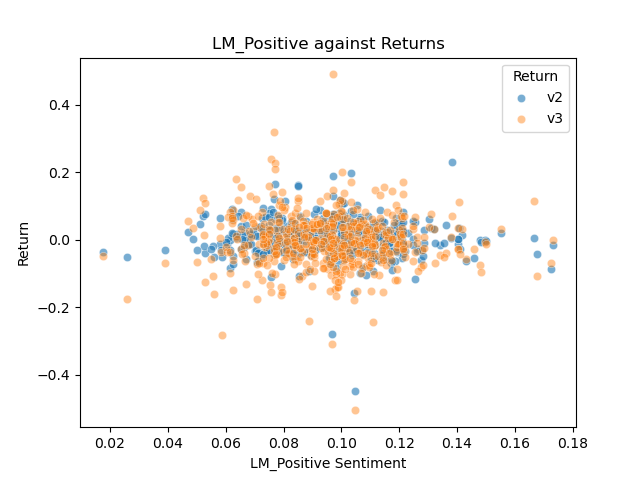

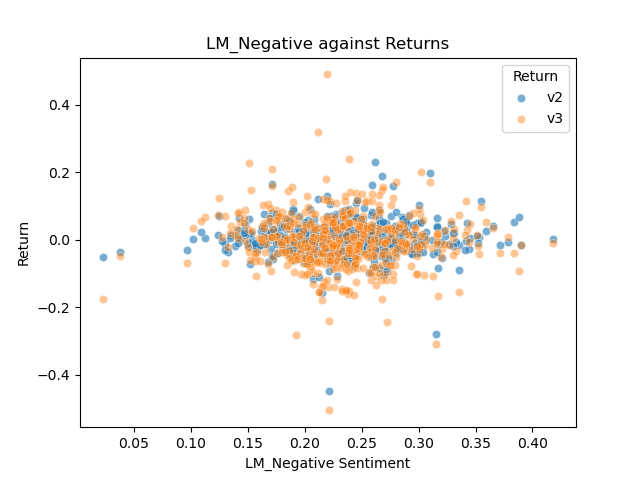

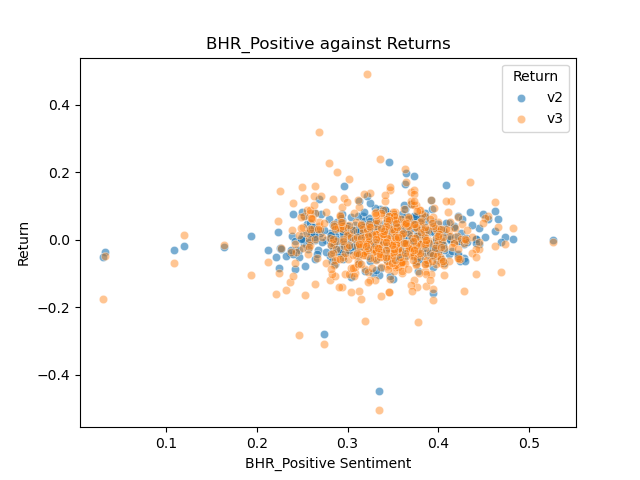

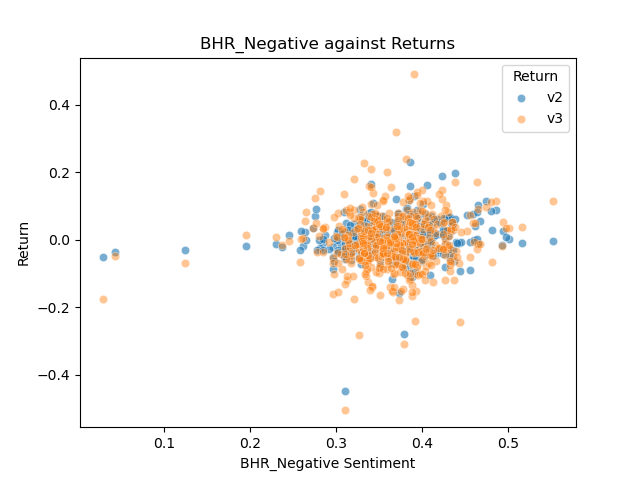

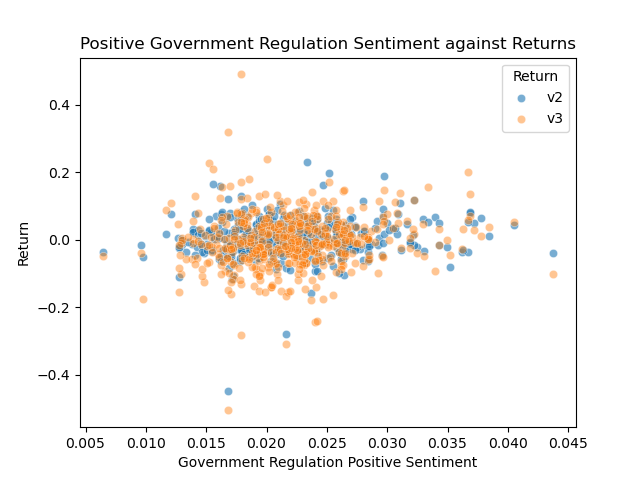

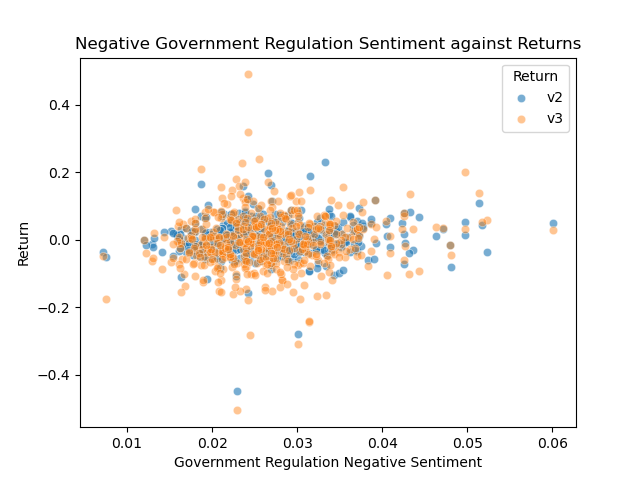

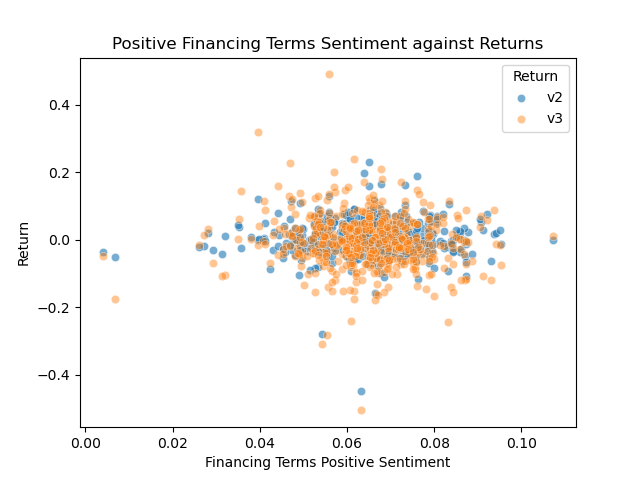

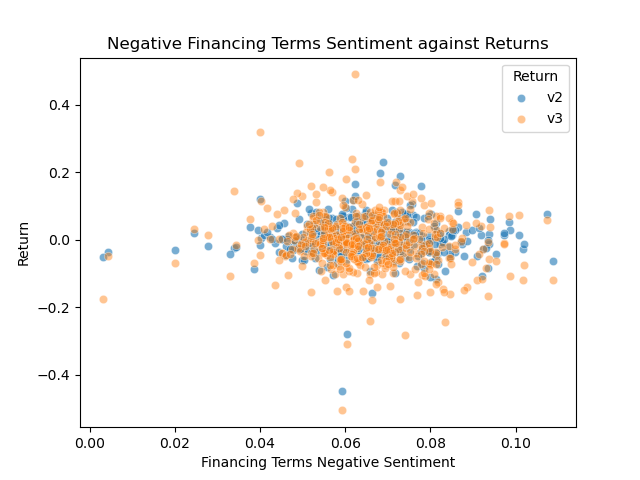

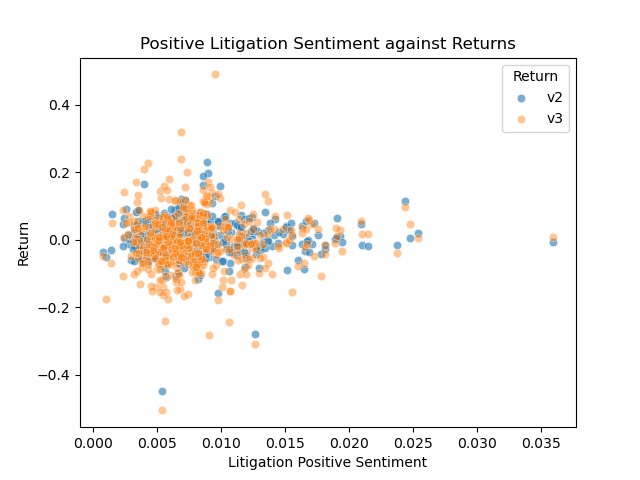

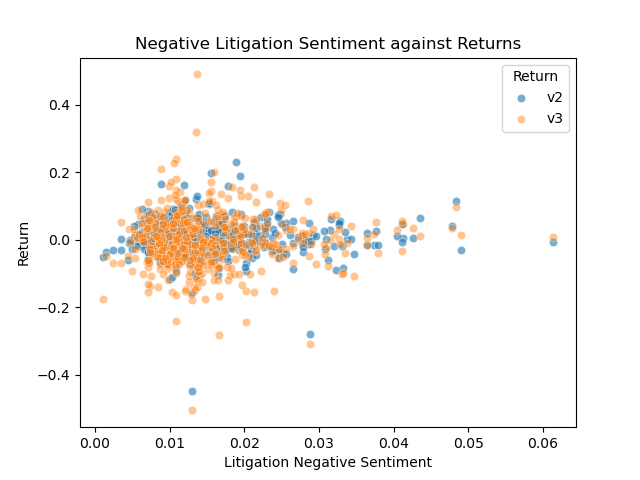

In [3]:
from IPython.display import Image
from IPython.display import display

LMpos = Image(filename='output/charts/LM_pos_plot.png') 
LMneg = Image(filename='output/charts/LM_neg_plot.png')
MLpos = Image(filename='output/charts/BHR_pos_plot.png') 
MLneg = Image(filename='output/charts/BHR_neg_plot.png') 
top1pos = Image(filename='output/charts/topic1_pos_plot.png') 
top1neg = Image(filename='output/charts/topic1_neg_plot.png') 
top2pos = Image(filename='output/charts/topic2_pos_plot.png') 
top2neg = Image(filename='output/charts/topic2_neg_plot.png') 
top3pos = Image(filename='output/charts/topic3_pos_plot.png') 
top3neg = Image(filename='output/charts/topic3_neg_plot.png') 

display(LMpos,LMneg,MLpos,MLneg,top1pos,top1neg,top2pos,top2neg,top3pos,top3neg)

Compare / contrast the relationship between the returns variable and the two “LM Sentiment” variables (positive and negative) with the relationship between the returns variable and the two “ML Sentiment” variables (positive and negative). Focus on the patterns of the signs of the relationships and the magnitudes.
- The patterns of both LM and ML charts are very similar, however the machine learning dictionary has comparatively higher sentiment scores consistent with both positive and negative, attributed to the differences in the sizes of the dictionaries. We would expect a positive correlation for the positive sentiment charts and a negative correlation for the negative sentiment charts. The data suggests, with the low correlations and no discernable pattern, neither positive nor negative sentiment scores have an effect on return. While it is difficult to say the sentiment has **NO** effect on return, there are many other factors that go into stock pricing. To more accurately predict returns we must consider those variables as well.

If your comparison/contrast conflicts with Table 3 of the Garcia, Hu, and Rohrer paper (ML_JFE.pdf, in the repo), discuss and brainstorm possible reasons why you think the results may differ. If your patterns agree, discuss why you think they bothered to include so many more firms and years and additional controls in their study? (It was more work than we did on this midterm, so why do it to get to the same point?)
- Our results are similar, not much difference in return compared to sentiment. They included much more data because they had the means to, and a larger sample size is always beneficial in a statistical analysis. More firms also allows for analysis based on the growth of an industry, for example. More years of return data also factors in macroeconomic factors that have an effect on the market as a whole. The analysis I conducted for this report only considers 2022, which is a small sample dictated by the direction of the market.

Discuss your 3 “contextual” sentiment measures. Do they have a relationship with returns that looks “different enough” from zero to investigate further? If so, make an economic argument for why sentiment in that context can be value relevant.
- For each different topic, I notice a relationship that the highest and lowest returns have similar sentiment scores across the board, for both positive and negative. This is indicated by an implied vertical line near the highest and lowest returns.

Is there a difference in the sign and magnitude? Speculate on why or why not.
- I am not noticing a difference between sign and magnitude. This makes sense because the data is so loosely correlated and there seems to be a pretty even distribution of positive and negative returns.
